# CLASSIFIEZ AUTOMATIQUEMENT DES BIENS DE CONSOMMATION

# Classification supervisée à partir des images du jeu de données

## Contexte

Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.

Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.

Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser cette tâche.

Voici le deuxième mail de Linda.

Merci beaucoup pour ton travail !

Bravo d’avoir démontré la faisabilité de regrouper automatiquement des produits de même catégorie !

Maintenant, je te propose de passer à la deuxième itération. Pourrais-tu réaliser une classification supervisée à partir des images ? Je souhaiterais que tu mettes en place une data augmentation afin d’optimiser le modèle.

Nous souhaitons élargir notre gamme de produits, en particulier dans l’épicerie fine. Pourrais-tu tester la collecte de produits à base de “champagne” via l’API disponible ici ? Je souhaiterais que tu puisses nous fournir une extraction des 10 premiers produits dans un fichier “.csv”, contenant pour chaque produit les données suivantes : foodId, label, category, foodContentsLabel, image.

Merci encore,

Linda

## Remarques
- **Si non n'avions pas montré la faisabilité de la classification des produits selon leur catégorie à partir des images, ce notebook n'aurait pas été réalisé. En effet, la précédente étape a été très rapide en mettre en place. Ainsi, une conclusion négative sur la faisabilité aurait évité de réaliser des traitements beaucoup plus lourds de classification supervisée Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Data.**
- **Il existe plusieurs approches de classification supervisée pour les images avec notamment une data augmentation ou non. Ici, 2 approches seront testées:**
    - **Approche par DataSet, sans data augmentation**
    - **Approche par DataSet, avec data augmentation: La data augmentation repose sur le principe d’augmenter artificiellement les données, en y appliquant des transformations (bruit, rotation, contraste, flou, déformation...).**

In [1]:
# Import des librairies classiques 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time

# Import des librairies pour la réduction dimensionnelle et le clustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, adjusted_rand_score, confusion_matrix, classification_report

# Import pour le traitement d'images et le deep learning
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# import keras_tuner as kt

# PREPARATION DU DATASET

## 1. Import et copie du dataset 

In [2]:
# Import du jeu de données
file = pd.read_csv("C:\\Users\\colin\\Documents\\Formation_Openclassrooms\\Projet6_ClassifierAutomatiquementdesBiens\\path_images_cleaned.csv")
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
file.head()

,image,main_category,path_image,processed_images
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,home furnishing,Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg,Images_processed\55b85ea15a1536d46b7190ad6fff8...
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,baby care,Images/7b72c92c2f6c40268628ec5f14c6d590.jpg,Images_processed\7b72c92c2f6c40268628ec5f14c6d...
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,baby care,Images/64d5d4a258243731dc7bbb1eef49ad74.jpg,Images_processed\64d5d4a258243731dc7bbb1eef49a...
3,d4684dcdc759dd9cdf41504698d737d8.jpg,home furnishing,Images/d4684dcdc759dd9cdf41504698d737d8.jpg,Images_processed\d4684dcdc759dd9cdf41504698d73...
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,home furnishing,Images/6325b6870c54cd47be6ebfbffa620ec7.jpg,Images_processed\6325b6870c54cd47be6ebfbffa620...


In [3]:
# Copie du fichier
df = file.copy()

## 2. Elimination des variables inutiles

**Dans ce notebook, seules les variables main_category et path_images seront utiles. C'est pourquoi les 2 autres variables seront éliminées du jeu de données.**

In [4]:
# Elimination des 2 variables
df = df.drop(["image", "processed_images"], axis= 1)
df.head()

,main_category,path_image
0,home furnishing,Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,baby care,Images/7b72c92c2f6c40268628ec5f14c6d590.jpg
2,baby care,Images/64d5d4a258243731dc7bbb1eef49ad74.jpg
3,home furnishing,Images/d4684dcdc759dd9cdf41504698d737d8.jpg
4,home furnishing,Images/6325b6870c54cd47be6ebfbffa620ec7.jpg


In [5]:
# Encodage de la catégorie
encoder= LabelEncoder()
df["class"] = encoder.fit_transform(df["main_category"])
df.head()

,main_category,path_image,class
0,home furnishing,Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg,4
1,baby care,Images/7b72c92c2f6c40268628ec5f14c6d590.jpg,0
2,baby care,Images/64d5d4a258243731dc7bbb1eef49ad74.jpg,0
3,home furnishing,Images/d4684dcdc759dd9cdf41504698d737d8.jpg,4
4,home furnishing,Images/6325b6870c54cd47be6ebfbffa620ec7.jpg,4


# VGG16

**Pour le modèle VGG16, les images doivent être obligatoirement redimensionnées en 224x224. Une fois les images préparées, ces dernières seront utilisées pour le test de 4 modèles VGG16:**
- **2 modèles sans data augmentation:**
    - **Un modèle avec une taille de bactch de 64**
    - **Un modèle avec une taille de bactch de 32**
- **2 modèles avec data augmentation:**
    - **Un modèle avec une taille de bactch de 64**
    - **Un modèle avec une taille de bactch de 32**    

## Préparation initiale des images

In [6]:
def image_prep_fct() :
    prepared_images = []
    for image_num in range(len(df['path_image'])) :
        img = (load_img(df['path_image'][image_num], target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np
    
images_np = image_prep_fct()
print(images_np.shape)

C:\Users\colin\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(1050, 224, 224, 3)


# 1. VGG16 sans data augmentation

## 1.1. Création du premier modèle avec un batch size de 64

- **Explications de certains paramètres:**
    - **include_top =False**: N'inclut pas the full-connected layers permettant ainsi de s'adapter à notre jeu de données (pour imagenet, 1000 neurones en sortie).
    - **Dropout**: Evite l'overfitting
    - **rmsprop**: Algorithme populaire d'optimisation
    
- **Métriques appropriées aux problèmes de classification multi_classes:**
    - **activation = "softmax"**
    - **loss = "categorical_crossentropy"**

### 1. Fonction permettant la création du modèle VGG16 sans data augmentation

In [7]:
def vgg16_no_aug():
    
    # Récupération modèle pré-entraîné
    model_vgg16_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model_vgg16_base.layers:
        layer.trainable = False

    # Récupération de la sortie de ce réseau
    x = model_vgg16_base.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définition du nouveau modèle
    model = Model(inputs=model_vgg16_base.input, outputs=predictions)
    
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

### 2. Séparation du jeu de données

**Concernant le jeu de données, ce dernier sera séparé en 3 jeux avec une stratification sur y:**
- **Un jeu d'entrainement comprenant 75% des données**
- **Un jeu de test comprenant 15% des données**
- **Un jeu de validation comprenant 15% des données**

**Bien qu'un LabelEncoder avait été préalablement réalisé sur les catégories de produits, pour la target j'ai été obligé de réaliser la ligne de code ci-dessous.**

In [8]:
# Séparation des données en X et y
X = images_np
y = to_categorical(df["class"], num_classes=7)


# Split en jeu d'entraînement (70%) et en jeu temporaire (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)

# Split du jeu temporaire en jeux de validation (15%) et de test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

X_train shape: (735, 224, 224, 3)
X_test shape: (158, 224, 224, 3)
y_train shape: (735, 7)
y_test shape: (158, 7)
X_val shape: (157, 224, 224, 3)
y_val shape: (157, 7)


### 3. Création du modèle 

**Explication du modèle**
- **Le ModelCheckpoint permet la sauvegarde du modèle à certains intervalles. Ici, il n'y aura qu'une seule sauvegarde au moment où le val_loss atteindra son minimum.**
- **La patience peut entrainer un arrêt prématuré du modèle. Ici, si 5 epochs consécutifs n'entraine pas de diminution de la val-loss, alors l'entraînement du modèle cessera.**

In [9]:
# Création du modèle
with tf.device('/gpu:0'): 
    model5 = vgg16_no_aug()

# Création du callback
model5_save_path = "./model5_best_weights.h5"
checkpoint_5 = ModelCheckpoint(model5_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es_5 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list_5 = [checkpoint_5, es_5]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 4. Entrainement du modèle sur les données d'entraînement

In [10]:
with tf.device('/gpu:0'): 
    history5 = model5.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list_5, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 6.5674 - accuracy: 0.3823
Epoch 1: val_loss improved from inf to 1.45201, saving model to .\model5_best_weights.h5
12/12 [==============================] - 120s 10s/step - loss: 6.5674 - accuracy: 0.3823 - val_loss: 1.4520 - val_accuracy: 0.7325
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 2.3068 - accuracy: 0.6857
Epoch 2: val_loss improved from 1.45201 to 1.34526, saving model to .\model5_best_weights.h5
12/12 [==============================] - 129s 11s/step - loss: 2.3068 - accuracy: 0.6857 - val_loss: 1.3453 - val_accuracy: 0.7962
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 1.3984 - accuracy: 0.7810
Epoch 3: val_loss improved from 1.34526 to 1.30976, saving model to .\model5_best_weights.h5
12/12 [==============================] - 123s 10s/step - loss: 1.3984 - accuracy: 0.7810 - val_loss: 1.3098 - val_accuracy: 0.7771
Epoch 4/50
12/12 [==============================] 

**Le modèle s'est bien arrêté avec les 50 epochs (réalisation de 19 Epoch).**

### 5. Visualisation de la performance et de la 'perte'

In [11]:
# Score du dernier epoch

loss_5, accuracy_5 = model5.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy_5))
print()
loss_5, accuracy_5 = model5.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy_5))

23/23 [==============================] - 101s 4s/step - loss: 0.0084 - accuracy: 0.9986
Training Accuracy: 0.9986

5/5 [==============================] - 22s 4s/step - loss: 0.9576 - accuracy: 0.8280
Validation Accuracy:  0.8280


In [44]:
# Score de l'epoch optimal

model5.load_weights(model5_save_path)

loss_5, accuracy_5 = model5.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_5))
print("Validation Loss     :  {:.4f}".format(loss_5))
print()
loss_5, accuracy_5 = model5.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_5))
print("Test Loss           :  {:.4f}".format(loss_5))

Validation Accuracy :  0.8344
Validation Loss     :  0.8869

Test Accuracy       :  0.8228
Test Loss           :  0.7255


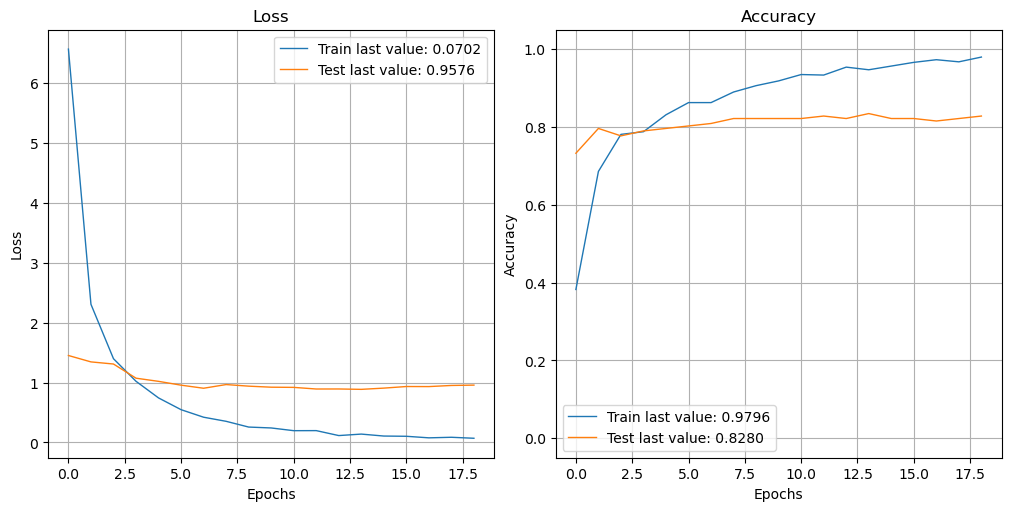

In [13]:
from plot_keras_history import show_history, plot_history

show_history(history5)
plot_history(history5, path="adam_1.png")
plt.close()

### 6. Matrice de confusion et rapport de classification sur le meilleur epoch

**1. RECUPERATION DES DONNEES DU MEILLEUR EPOCH**

In [14]:
y_val_num_vgg16_base_1 = np.argmax(y_val, axis=1)
y_val_pred_vgg16_base_1 = np.argmax(model5.predict(X_val), axis=1)

print(y_val_num_vgg16_base_1)
print()
print(y_val_pred_vgg16_base_1)

5/5 [==============================] - 24s 5s/step
[3 4 1 2 4 2 5 1 2 6 6 1 3 1 5 3 2 1 5 0 5 5 6 3 3 2 2 1 2 6 3 4 3 1 5 3 6
 6 0 1 2 0 2 0 0 0 6 3 3 2 2 2 4 5 4 0 1 0 3 3 0 0 0 2 6 3 4 2 1 1 3 3 0 4
 0 3 3 6 4 3 1 2 4 4 1 1 6 3 3 6 6 6 4 6 5 5 4 6 4 6 1 1 4 0 5 5 0 5 0 5 6
 5 1 0 3 6 2 5 4 6 3 4 5 1 0 0 2 1 4 4 5 6 1 4 1 0 2 0 2 5 5 1 2 6 1 5 6 4
 5 6 0 4 4 2 5 2 5]

[5 4 1 2 0 2 5 2 2 6 6 1 3 1 5 3 1 1 5 0 5 5 6 3 5 2 2 1 3 6 3 4 5 1 5 3 6
 6 5 1 2 0 2 0 4 0 6 3 3 2 2 2 4 5 4 0 1 2 5 0 0 0 4 2 6 3 4 1 1 1 3 3 0 4
 0 3 3 6 4 3 1 2 4 0 1 1 6 3 5 6 6 6 4 6 3 5 4 6 4 6 1 1 4 0 4 5 4 6 0 5 2
 5 1 0 3 6 2 5 4 6 3 4 5 1 0 4 2 1 4 4 5 6 1 4 1 0 2 0 3 5 5 3 2 6 5 5 6 4
 5 6 0 0 4 2 5 2 5]


**2. MATRICE DE CONFUSION**

In [15]:
list(encoder.classes_)

['baby care ',
 'beauty and personal care ',
 'computers ',
 'home decor and festive needs ',
 'home furnishing ',
 'kitchen and dining ',
 'watches ']

In [16]:
labels= ['baby care','beauty and personal care','computers', 'home decor and festive needs', 'home furnishing','kitchen and dining','watches']

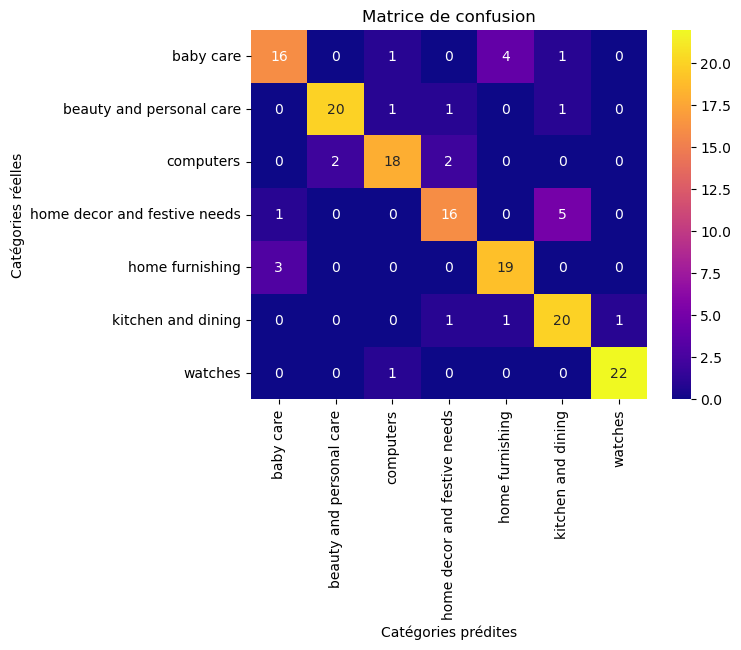

In [17]:
conf_mat_vgg16_base_1 = confusion_matrix(y_val_num_vgg16_base_1, y_val_pred_vgg16_base_1)

plt.figure()
with sns.color_palette(palette="pastel"):
    plt.rcParams.update({"font.size": 10})
    sns.heatmap(data=conf_mat_vgg16_base_1, cmap=plt.cm.plasma, annot=True)
    plt.title("Matrice de confusion")
    plt.xlabel("Catégories prédites")
    plt.ylabel("Catégories réelles")
    labels = ['baby care', 'beauty and personal care', 'computers', 'home decor and festive needs', 'home furnishing', 'kitchen and dining', 'watches']
    plt.xticks(np.arange(len(labels)) + 0.5, labels, rotation='vertical')
    plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation='horizontal')

plt.show()

**REMARQUE**: Nous pouvons constater que les principales erreurs se trouvent entre les catégories 'baby care' et "home furnishing", ce qui était déjà le cas pour le NLP!!!

**3. LE RAPPORT DE CLASSIFICATION**

In [18]:
target_names = ['baby care', 'beauty and personal care', 'computers', 'home decor and festive needs', 'home furnishing', "kitchen and dining", 'watches']
print(classification_report(y_val_num_vgg16_base_1, y_val_pred_vgg16_base_1, target_names=target_names))

                              precision    recall  f1-score   support

                   baby care       0.80      0.73      0.76        22
    beauty and personal care       0.91      0.87      0.89        23
                   computers       0.86      0.82      0.84        22
home decor and festive needs       0.80      0.73      0.76        22
             home furnishing       0.79      0.86      0.83        22
          kitchen and dining       0.74      0.87      0.80        23
                     watches       0.96      0.96      0.96        23

                    accuracy                           0.83       157
                   macro avg       0.84      0.83      0.83       157
                weighted avg       0.84      0.83      0.83       157



## 1.2. Création du premier modèle avec un batch size de 32

**Ce modèle sera quasi-similaire au précédent. En effet, seule la taille du batch sera modifiée: 32 au lieu de 64.**

### 1. Création du modèle

In [19]:
# Création du modèle
with tf.device('/gpu:0'): 
    model6 = vgg16_no_aug()

# Création du callback
model6_save_path = "./model6_best_weights.h5"
checkpoint_6 = ModelCheckpoint(model6_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es_6 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list_6 = [checkpoint_6, es_6]

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### 2. Entrainement du modèle sur les données d'entraînement

In [20]:
with tf.device('/gpu:0'): 
    history6 = model6.fit(X_train, y_train, epochs=50, batch_size=32, 
                       callbacks=callbacks_list_6, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 5.6019 - accuracy: 0.4408
Epoch 1: val_loss improved from inf to 1.47919, saving model to .\model6_best_weights.h5
23/23 [==============================] - 134s 6s/step - loss: 5.6019 - accuracy: 0.4408 - val_loss: 1.4792 - val_accuracy: 0.7834
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 1.6120 - accuracy: 0.7361
Epoch 2: val_loss improved from 1.47919 to 1.19894, saving model to .\model6_best_weights.h5
23/23 [==============================] - 134s 6s/step - loss: 1.6120 - accuracy: 0.7361 - val_loss: 1.1989 - val_accuracy: 0.7771
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 0.8262 - accuracy: 0.8122
Epoch 3: val_loss improved from 1.19894 to 1.05408, saving model to .\model6_best_weights.h5
23/23 [==============================] - 128s 6s/step - loss: 0.8262 - accuracy: 0.8122 - val_loss: 1.0541 - val_accuracy: 0.7643
Epoch 4/50
23/23 [==============================] - E

**Comme précédemment, l'entraînement du modèle s'est arrétée avant les 50 Epoch. Ici, 14 Epoch ont été réalisés.**

### 3. Visualisation de la performance et de la 'perte'

In [21]:
# Score du dernier epoch

loss_6, accuracy_6 = model6.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy_6))
print()
loss_6, accuracy_6 = model6.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy_6))

23/23 [==============================] - 113s 5s/step - loss: 0.0095 - accuracy: 1.0000
Training Accuracy: 1.0000

5/5 [==============================] - 22s 4s/step - loss: 1.0290 - accuracy: 0.7771
Validation Accuracy:  0.7771


In [45]:
# Score de l'epoch optimal

model6.load_weights(model6_save_path)

loss_6, accuracy_6 = model6.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_6))
print("Validation Loss     :  {:.4f}".format(loss_6))
print()
loss_6, accuracy_6 = model6.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_6))
print("Test Loss           :  {:.4f}".format(loss_6))

Validation Accuracy :  0.8089
Validation Loss     :  0.9473

Test Accuracy       :  0.8354
Test Loss           :  0.6439


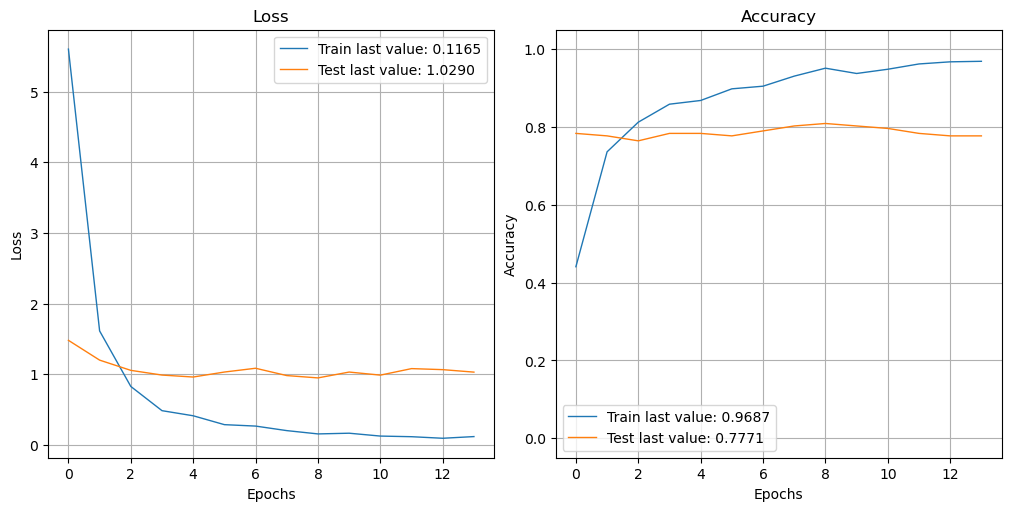

In [23]:
show_history(history6)
plot_history(history6, path="adam_2.png")
plt.close()

### 4. Matrice de confusion et rapport de classification sur le meilleur epoch

**1. RECUPERATION DES DONNEES DU MEILLEUR EPOCH**

In [24]:
y_val_num_vgg16_base_2 = np.argmax(y_val, axis=1)
y_val_pred_vgg16_base_2 = np.argmax(model6.predict(X_val), axis=1)

print(y_val_num_vgg16_base_2)
print()
print(y_val_pred_vgg16_base_2)

5/5 [==============================] - 23s 5s/step
[3 4 1 2 4 2 5 1 2 6 6 1 3 1 5 3 2 1 5 0 5 5 6 3 3 2 2 1 2 6 3 4 3 1 5 3 6
 6 0 1 2 0 2 0 0 0 6 3 3 2 2 2 4 5 4 0 1 0 3 3 0 0 0 2 6 3 4 2 1 1 3 3 0 4
 0 3 3 6 4 3 1 2 4 4 1 1 6 3 3 6 6 6 4 6 5 5 4 6 4 6 1 1 4 0 5 5 0 5 0 5 6
 5 1 0 3 6 2 5 4 6 3 4 5 1 0 0 2 1 4 4 5 6 1 4 1 0 2 0 2 5 5 1 2 6 1 5 6 4
 5 6 0 4 4 2 5 2 5]

[5 4 1 2 0 6 5 2 2 6 6 1 3 5 5 3 1 1 5 0 5 5 3 3 3 2 3 1 3 6 3 0 5 1 5 3 6
 6 5 1 2 0 2 0 0 0 5 3 3 2 2 2 4 3 4 0 1 2 3 0 4 0 4 2 6 3 4 1 1 1 3 3 0 4
 0 3 3 6 4 3 1 2 0 4 1 1 6 3 5 6 6 6 0 6 3 5 4 6 4 6 1 1 4 0 4 5 4 5 0 5 5
 5 1 0 3 6 2 5 4 6 3 4 5 1 0 4 2 1 4 4 5 6 1 4 1 0 2 0 3 5 5 3 2 6 5 5 6 4
 5 6 0 4 4 2 5 2 5]


**2. MATRICE DE CONFUSION**

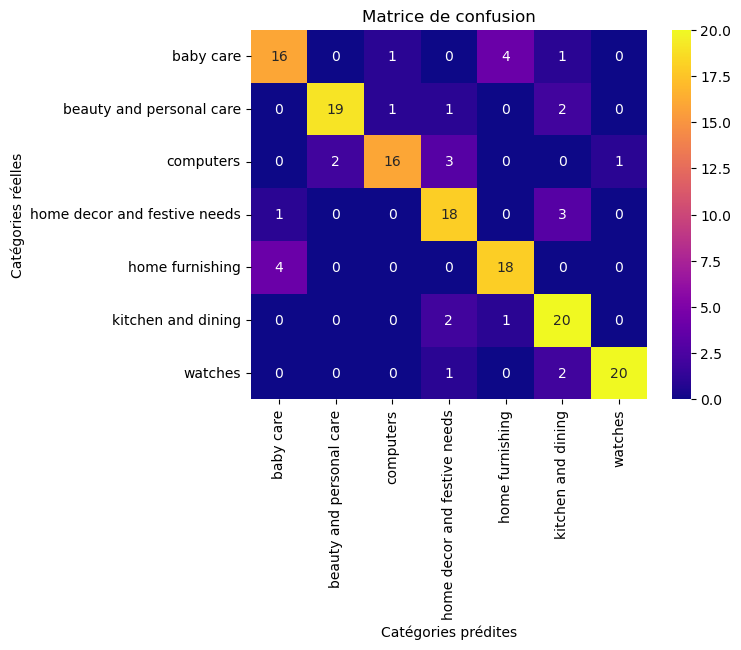

In [25]:
conf_mat_vgg16_base_2 = confusion_matrix(y_val_num_vgg16_base_2, y_val_pred_vgg16_base_2)

plt.figure()
with sns.color_palette(palette="pastel"):
    plt.rcParams.update({"font.size": 10})
    sns.heatmap(data=conf_mat_vgg16_base_2, cmap=plt.cm.plasma, annot=True)
    plt.title("Matrice de confusion")
    plt.xlabel("Catégories prédites")
    plt.ylabel("Catégories réelles")
    labels = ['baby care', 'beauty and personal care', 'computers', 'home decor and festive needs', 'home furnishing', 'kitchen and dining', 'watches']
    plt.xticks(np.arange(len(labels)) + 0.5, labels, rotation='vertical')
    plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation='horizontal')

plt.show()

**3. LE RAPPORT DE CLASSIFICATION**

In [26]:
target_names = ['baby care', 'beauty and personal care', 'computers', 'home decor and festive needs', 'home furnishing', "kitchen and dining", 'watches']
print(classification_report(y_val_num_vgg16_base_2, y_val_pred_vgg16_base_2, target_names=target_names))

                              precision    recall  f1-score   support

                   baby care       0.76      0.73      0.74        22
    beauty and personal care       0.90      0.83      0.86        23
                   computers       0.89      0.73      0.80        22
home decor and festive needs       0.72      0.82      0.77        22
             home furnishing       0.78      0.82      0.80        22
          kitchen and dining       0.71      0.87      0.78        23
                     watches       0.95      0.87      0.91        23

                    accuracy                           0.81       157
                   macro avg       0.82      0.81      0.81       157
                weighted avg       0.82      0.81      0.81       157



# 2. VGG16 avec data augmentation

**Le but est d'augmenter artificiellement les images en leur appliquant diverses transformations (Zoom, Rotation, Changement d'échelle, Flip...). Nous allons donc 'rejouer' les 2 modèles précédents avec les mêmes paramètres mais en appliquant des transformations aux images.**

## 2.1. Création du premier modèle avec un batch size de 64

### 1. Création du modèle

In [27]:
def vgg16_with_aug():
    
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1)])
    
    # Récupération modèle pré-entraîné
    model_vgg16_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model_vgg16_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_vgg16_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model

In [28]:
with tf.device('/gpu:0'): 
    model7 = vgg16_with_aug()

# Création du callback
model7_save_path = "./model7_best_weights.h5"
checkpoint_7 = ModelCheckpoint(model7_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es_7 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list_7 = [checkpoint_7, es_7]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

### 2. Entrainement du modèle sur les données d'entraînement

In [29]:
# Entraînenement sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history7 = model7.fit(X_train, y_train, epochs=50, batch_size=64, 
                       callbacks=callbacks_list_7, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 1.8530 - accuracy: 0.2585
Epoch 1: val_loss improved from inf to 1.47994, saving model to .\model7_best_weights.h5
12/12 [==============================] - 136s 11s/step - loss: 1.8530 - accuracy: 0.2585 - val_loss: 1.4799 - val_accuracy: 0.6624
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 1.4563 - accuracy: 0.5224
Epoch 2: val_loss improved from 1.47994 to 1.15390, saving model to .\model7_best_weights.h5
12/12 [==============================] - 133s 11s/step - loss: 1.4563 - accuracy: 0.5224 - val_loss: 1.1539 - val_accuracy: 0.7325
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 1.2002 - accuracy: 0.6082
Epoch 3: val_loss improved from 1.15390 to 0.97031, saving model to .\model7_best_weights.h5
12/12 [==============================] - 130s 11s/step - loss: 1.2002 - accuracy: 0.6082 - val_loss: 0.9703 - val_accuracy: 0.7197
Epoch 4/50
12/12 [==============================] 

12/12 [==============================] - 119s 10s/step - loss: 0.5796 - accuracy: 0.8204 - val_loss: 0.6798 - val_accuracy: 0.7707
Epoch 20/50
12/12 [==============================] - ETA: 0s - loss: 0.5512 - accuracy: 0.8136
Epoch 20: val_loss did not improve from 0.67618
12/12 [==============================] - 116s 10s/step - loss: 0.5512 - accuracy: 0.8136 - val_loss: 0.6850 - val_accuracy: 0.7643
Epoch 21/50
12/12 [==============================] - ETA: 0s - loss: 0.5392 - accuracy: 0.8286
Epoch 21: val_loss did not improve from 0.67618
12/12 [==============================] - 115s 10s/step - loss: 0.5392 - accuracy: 0.8286 - val_loss: 0.6878 - val_accuracy: 0.7643
Epoch 22/50
12/12 [==============================] - ETA: 0s - loss: 0.5495 - accuracy: 0.8163
Epoch 22: val_loss did not improve from 0.67618
12/12 [==============================] - 117s 10s/step - loss: 0.5495 - accuracy: 0.8163 - val_loss: 0.6774 - val_accuracy: 0.7771
Epoch 22: early stopping


**De même que pour la classification sans data augmentation, le modèle s'est bien arrêté avec les 50 epochs, avec toutefois plus d'Epoch réalisés (22 versus 14).**

### 3. Visualisation de la performance et de la 'perte'¶

In [30]:
# Score du dernier epoch

loss_7, accuracy_7 = model7.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy_7))
print()
loss_7, accuracy_7 = model7.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy_7))

23/23 [==============================] - 96s 4s/step - loss: 0.3828 - accuracy: 0.8830
Training Accuracy   : 0.8830

5/5 [==============================] - 21s 4s/step - loss: 0.6774 - accuracy: 0.7771
Validation Accuracy :  0.7771


In [46]:
# Score de l'epoch optimal

model7.load_weights(model7_save_path)

loss_7, accuracy_7 = model7.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_7))
print("Validation Loss     :  {:.4f}".format(loss_7))
print()
loss_7, accuracy_7 = model7.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_7))
print("Test Loss           :  {:.4f}".format(loss_7))

Validation Accuracy :  0.7834
Validation Loss     :  0.6762

Test Accuracy       :  0.8228
Test Loss           :  0.5693


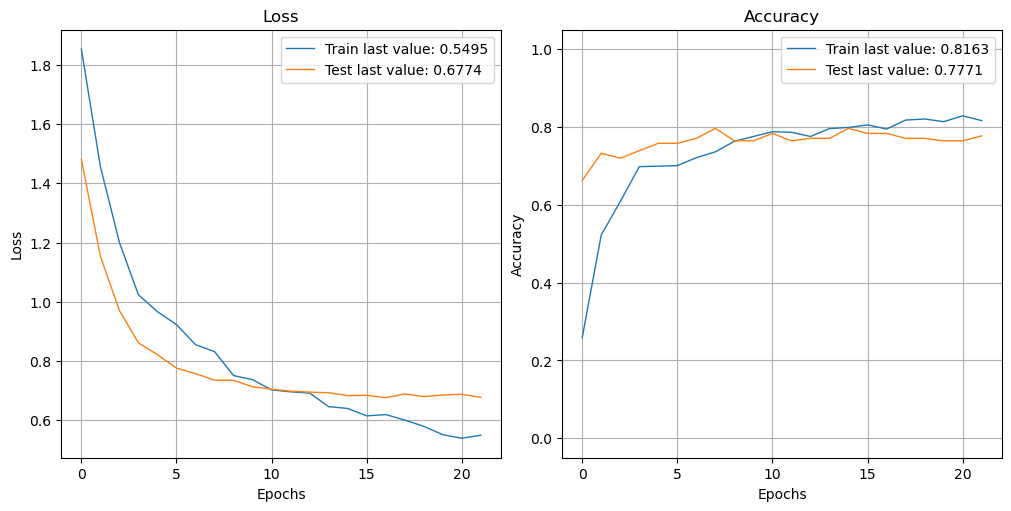

In [32]:
show_history(history7)
plot_history(history7, path="adam_3.png")
plt.close()

### 4. Matrice de confusion et rapport de classification sur le meilleur epoch¶

**1. RECUPERATION DES DONNEES DU MEILLEUR EPOCH**

In [33]:
y_val_num_vgg16_aug_1 = np.argmax(y_val, axis=1)
y_val_pred_vgg16_aug_1 = np.argmax(model7.predict(X_val), axis=1)

print(y_val_num_vgg16_aug_1)
print()
print(y_val_pred_vgg16_aug_1)

5/5 [==============================] - 20s 4s/step
[3 4 1 2 4 2 5 1 2 6 6 1 3 1 5 3 2 1 5 0 5 5 6 3 3 2 2 1 2 6 3 4 3 1 5 3 6
 6 0 1 2 0 2 0 0 0 6 3 3 2 2 2 4 5 4 0 1 0 3 3 0 0 0 2 6 3 4 2 1 1 3 3 0 4
 0 3 3 6 4 3 1 2 4 4 1 1 6 3 3 6 6 6 4 6 5 5 4 6 4 6 1 1 4 0 5 5 0 5 0 5 6
 5 1 0 3 6 2 5 4 6 3 4 5 1 0 0 2 1 4 4 5 6 1 4 1 0 2 0 2 5 5 1 2 6 1 5 6 4
 5 6 0 4 4 2 5 2 5]

[5 4 1 2 0 3 5 2 2 6 6 1 3 2 5 3 1 1 0 0 5 5 2 3 3 2 5 1 2 6 3 4 3 1 2 3 6
 6 5 1 2 0 2 0 2 0 6 3 3 2 2 2 4 3 4 0 1 2 3 0 0 4 4 2 6 3 4 1 1 1 3 3 0 4
 0 3 3 6 0 3 1 2 0 4 1 1 6 3 5 6 6 6 2 6 2 5 4 6 4 6 1 1 4 0 3 5 4 6 0 5 5
 5 1 0 0 6 2 5 4 6 3 4 5 1 0 4 2 1 4 4 5 6 1 4 1 3 2 0 3 5 5 3 2 6 5 5 6 4
 3 6 0 4 4 2 5 2 5]


**2. LA MATRICE DE CONFUSION**

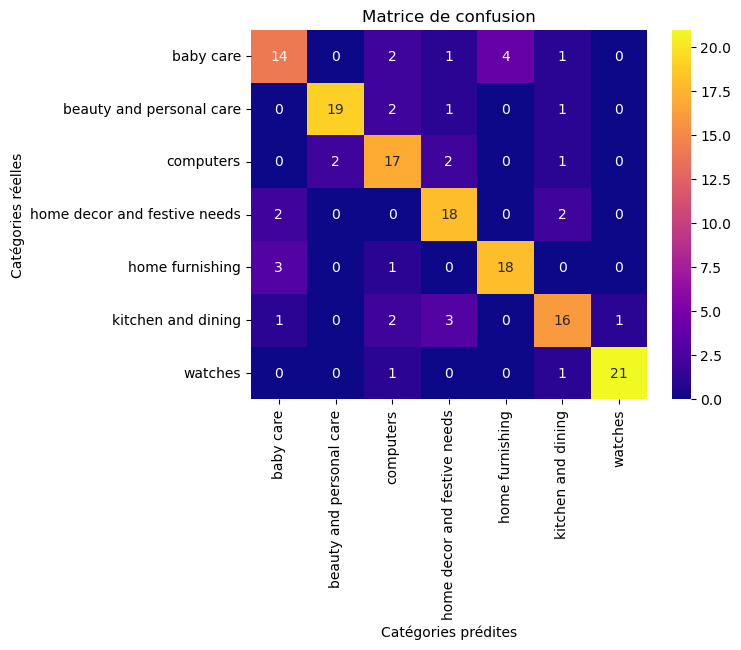

In [34]:
# Matrice de confusion
conf_mat_vgg16_aug_1 = confusion_matrix(y_val_num_vgg16_aug_1, y_val_pred_vgg16_aug_1)

plt.figure()
with sns.color_palette(palette="pastel"):
    plt.rcParams.update({"font.size": 10})
    sns.heatmap(data=conf_mat_vgg16_aug_1, cmap=plt.cm.plasma, annot=True)
    plt.title("Matrice de confusion")
    plt.xlabel("Catégories prédites")
    plt.ylabel("Catégories réelles")
    labels = ['baby care', 'beauty and personal care', 'computers', 'home decor and festive needs', 'home furnishing', 'kitchen and dining', 'watches']
    plt.xticks(np.arange(len(labels)) + 0.5, labels, rotation='vertical')
    plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation='horizontal')

plt.show()

**3. LE RAPPORT DE CLASSIFICATION**

In [35]:
target_names = ['baby care', 'beauty and personal care', 'computers', 'home decor and festive needs', 'home furnishing', "kitchen and dining", 'watches']
print(classification_report(y_val_num_vgg16_aug_1, y_val_pred_vgg16_aug_1, target_names=target_names))

                              precision    recall  f1-score   support

                   baby care       0.70      0.64      0.67        22
    beauty and personal care       0.90      0.83      0.86        23
                   computers       0.68      0.77      0.72        22
home decor and festive needs       0.72      0.82      0.77        22
             home furnishing       0.82      0.82      0.82        22
          kitchen and dining       0.73      0.70      0.71        23
                     watches       0.95      0.91      0.93        23

                    accuracy                           0.78       157
                   macro avg       0.79      0.78      0.78       157
                weighted avg       0.79      0.78      0.78       157



## 2.2. Création du premier modèle avec un batch size de 32

### 1. Création du modèle

In [36]:
with tf.device('/gpu:0'): 
    model8 = vgg16_with_aug()

# Création du callback
model8_save_path = "./model8_best_weights.h5"
checkpoint_8 = ModelCheckpoint(model8_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es_8 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list_8 = [checkpoint_8, es_8]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                      

### 2. Entrainement du modèle sur les données d'entraînement

In [37]:
# Entraînenement sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'): 
    history8 = model8.fit(X_train, y_train, epochs=50, batch_size=32, 
                       callbacks=callbacks_list_8, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: 1.8304 - accuracy: 0.2789
Epoch 1: val_loss improved from inf to 1.28177, saving model to .\model8_best_weights.h5
23/23 [==============================] - 122s 5s/step - loss: 1.8304 - accuracy: 0.2789 - val_loss: 1.2818 - val_accuracy: 0.6561
Epoch 2/50
23/23 [==============================] - ETA: 0s - loss: 1.2634 - accuracy: 0.6041
Epoch 2: val_loss improved from 1.28177 to 0.97094, saving model to .\model8_best_weights.h5
23/23 [==============================] - 120s 5s/step - loss: 1.2634 - accuracy: 0.6041 - val_loss: 0.9709 - val_accuracy: 0.7452
Epoch 3/50
23/23 [==============================] - ETA: 0s - loss: 1.0668 - accuracy: 0.6694
Epoch 3: val_loss improved from 0.97094 to 0.87494, saving model to .\model8_best_weights.h5
23/23 [==============================] - 120s 5s/step - loss: 1.0668 - accuracy: 0.6694 - val_loss: 0.8749 - val_accuracy: 0.7389
Epoch 4/50
23/23 [==============================] - E

De même que pour la classification sans data augmentation, le modèle s'est bien arrêté avec les 50 epochs, avec toutefois plus d'Epoch réalisés (19 versus 14).

### 3. Visualisation de la performance et de la 'perte'

In [38]:
# Score du dernier epoch

loss_8, accuracy_8 = model8.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy_8))
print()
loss_8, accuracy_8 = model8.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy_8))

23/23 [==============================] - 97s 4s/step - loss: 0.3507 - accuracy: 0.9034
Training Accuracy   : 0.9034

5/5 [==============================] - 21s 4s/step - loss: 0.6745 - accuracy: 0.7580
Validation Accuracy :  0.7580


In [47]:
# Score de l'epoch optimal

model8.load_weights(model8_save_path)

loss_8, accuracy_8 = model8.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy_8))
print("Validation Loss     :  {:.4f}".format(loss_8))
print()
loss_8, accuracy_8 = model8.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy_8))
print("Test Loss           :  {:.4f}".format(loss_8))

Validation Accuracy :  0.7771
Validation Loss     :  0.6742

Test Accuracy       :  0.8481
Test Loss           :  0.5366


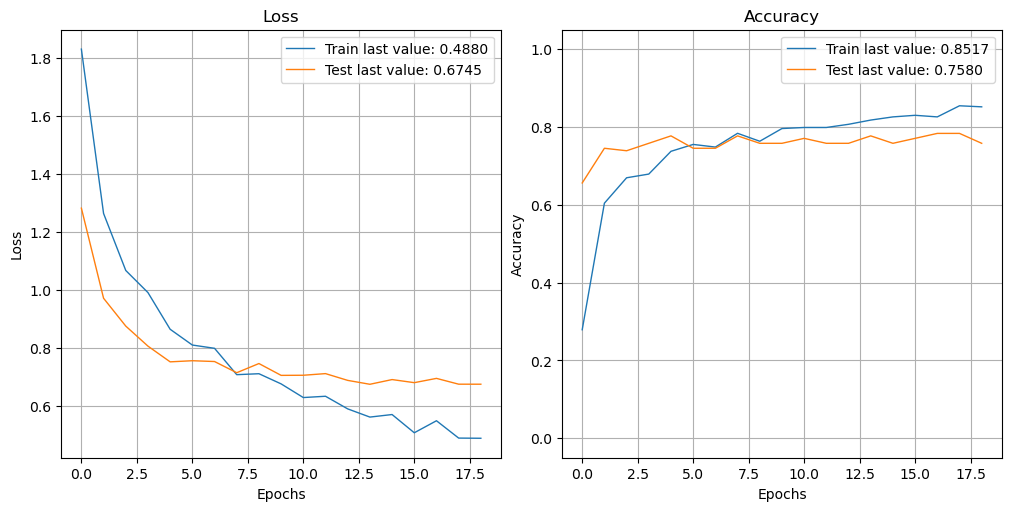

In [40]:
show_history(history8)
plot_history(history8, path="adam_4.png")
plt.close()

### 4. Matrice de confusion et rapport de classification sur le meilleur epoch

**1. RECUPERATION DES DONNEES DU MEILLEUR EPOCH**

In [41]:
y_val_num_vgg16_aug_2 = np.argmax(y_val, axis=1)
y_val_pred_vgg16_aug_2 = np.argmax(model8.predict(X_val), axis=1)

print(y_val_num_vgg16_aug_2)
print()
print(y_val_pred_vgg16_aug_2)

5/5 [==============================] - 21s 4s/step
[3 4 1 2 4 2 5 1 2 6 6 1 3 1 5 3 2 1 5 0 5 5 6 3 3 2 2 1 2 6 3 4 3 1 5 3 6
 6 0 1 2 0 2 0 0 0 6 3 3 2 2 2 4 5 4 0 1 0 3 3 0 0 0 2 6 3 4 2 1 1 3 3 0 4
 0 3 3 6 4 3 1 2 4 4 1 1 6 3 3 6 6 6 4 6 5 5 4 6 4 6 1 1 4 0 5 5 0 5 0 5 6
 5 1 0 3 6 2 5 4 6 3 4 5 1 0 0 2 1 4 4 5 6 1 4 1 0 2 0 2 5 5 1 2 6 1 5 6 4
 5 6 0 4 4 2 5 2 5]

[5 4 1 2 0 3 5 2 2 6 6 1 3 2 5 3 1 1 0 4 5 5 1 3 3 2 3 1 3 6 3 4 3 1 2 3 6
 6 5 1 2 0 2 0 3 0 6 3 3 2 2 2 4 3 4 0 1 2 3 0 0 4 4 2 6 3 0 1 1 1 3 3 0 4
 0 3 3 6 4 3 1 2 0 4 1 1 6 3 5 6 6 6 2 6 2 5 4 6 3 6 1 1 4 0 3 5 4 6 0 5 6
 5 1 0 3 6 2 5 4 6 3 4 5 1 0 4 2 1 4 4 5 6 1 4 1 3 2 0 3 5 5 3 2 6 5 5 6 4
 3 6 0 4 4 2 5 2 5]


**2. LA MATRICE DE CONFUSION**

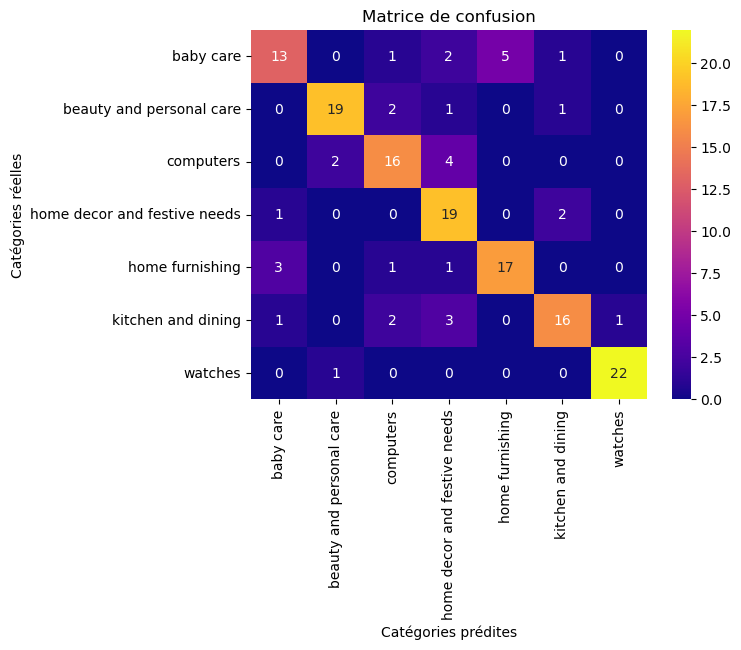

In [42]:
# Matrice de confusion
conf_mat_vgg16_aug_2 = confusion_matrix(y_val_num_vgg16_aug_2, y_val_pred_vgg16_aug_2)

plt.figure()
with sns.color_palette(palette="pastel"):
    plt.rcParams.update({"font.size": 10})
    sns.heatmap(data=conf_mat_vgg16_aug_2, cmap=plt.cm.plasma, annot=True)
    plt.title("Matrice de confusion")
    plt.xlabel("Catégories prédites")
    plt.ylabel("Catégories réelles")
    labels = ['baby care', 'beauty and personal care', 'computers', 'home decor and festive needs', 'home furnishing', 'kitchen and dining', 'watches']
    plt.xticks(np.arange(len(labels)) + 0.5, labels, rotation='vertical')
    plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation='horizontal')

plt.show()

**3. LE RAPPORT DE CLASSIFICATION**

In [43]:
target_names = ['baby care', 'beauty and personal care', 'computers', 'home decor and festive needs', 'home furnishing', "kitchen and dining", 'watches']
print(classification_report(y_val_num_vgg16_aug_2, y_val_pred_vgg16_aug_2, target_names=target_names))

                              precision    recall  f1-score   support

                   baby care       0.72      0.59      0.65        22
    beauty and personal care       0.86      0.83      0.84        23
                   computers       0.73      0.73      0.73        22
home decor and festive needs       0.63      0.86      0.73        22
             home furnishing       0.77      0.77      0.77        22
          kitchen and dining       0.80      0.70      0.74        23
                     watches       0.96      0.96      0.96        23

                    accuracy                           0.78       157
                   macro avg       0.78      0.78      0.78       157
                weighted avg       0.78      0.78      0.78       157



## CONCLUSION DE CE DEUXIEME NOTEBOOK DE CLASSIFICATION SUPERVISEE

### Le changement d'optimizer n'a pas permis d'obtenir de meilleurs résultats...

### MEILLEUR MODELE: VGG16 AVEC DATA AUGMENTATION, UN BATCH DE 64 ET LE RMSPROP EN OPTIMIZER